<a href="https://colab.research.google.com/github/artms-18/ML-Projects/blob/main/comp_vision_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification using the CIFAR dataset

## Importing required libraries

In [ ]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import pickle
import tarfile

from tensorflow import keras
from keras.layers import Conv2D, BatchNormalization, Activation, Add
from keras.layers import Input, AveragePooling2D
from keras.models import Model

In [ ]:
from google.colab import files
files.upload()

Saving cifar-10-python.tar.gz to cifar-10-python.tar.gz


## Extracting the dataset

In [ ]:
tar = tarfile.open("/content/cifar-10-python.tar.gz")
tar.extractall()
tar.close()

## Preprocessing

**Note** 

The CIFAR dataset contains images in batches to speed up training, additionally, they are formatted in the shape of a 10000x3072 numpy array (rgb). 

In [ ]:
def get_batches(file):
  batches = []
  for dirName, subdirList, fileList in os.walk(file):
    #print('Found directory: %s' % dirName)
    for fname in fileList:
      if "data_batch_" in fname:
        #print('\t%s' % fname)
        batches.append(str(fname))
  return batches

In [ ]:
batches = get_batches("/content/cifar-10-batches-py")

In [ ]:
def unpickle(file):
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding = 'bytes')
  return dict

In [ ]:
all_data = []
for batch in batches:
  all_data.append(unpickle("/content/cifar-10-batches-py" + "/" + batch))

In [ ]:
def shape(batch):

  """
  
  Reshapes and transposes images into correct shape for training

  Args: a dict for a batch of images with the shape (10000, 3072)
  Returns: a tuple containing (preprocessed images, labels)

  """
  images = batch[b'data'].reshape(len(batch[b'data']), 3, 32, 32).transpose(0, 2, 3, 1)
  labels = batch[b'labels']

  return images, labels

In [ ]:
preprocessed = []
for batch in all_data:
  preprocessed.append(shape(batch))

## Visualizing an image from the dataset

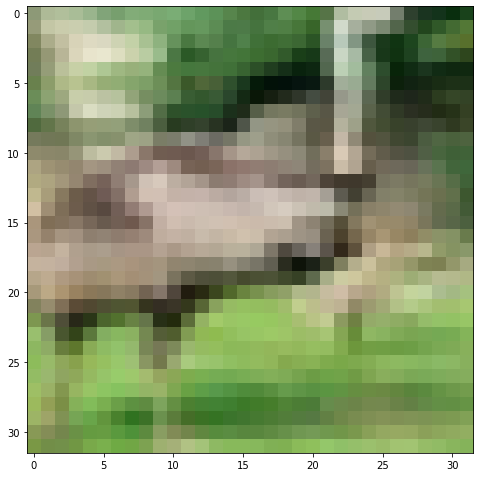

In [ ]:
#get random image

import random
random_index = random.randint(0, len(preprocessed[0][0]))
random_index

plt.figure(figsize = (8,12))
plt.imshow(preprocessed[0][0][random_index])

## More Preprocessing

In [ ]:
# normalize each image between values of 0-1 using the z-score normalization equation

def normalize(img):

  """

  Args: a numpy array with pixel values ranging from 0-255
  Returns: a normalized numpy array with values ranging between 0-1

  """

  min = np.min(img)
  max = np.max(img)
  normalized = (img - min) / (max - min) 

  normalized = tf.cast(normalized, dtype = tf.float32)

  return normalized


In [ ]:
# labels are integers ranging from 0-9 corresponding to indexes for a particular label in label dict

def one_hot_encode(label):

  """

  Args: an integer label ranging from 0-9

  Returns: a one-hot encoded version of the label with a '1' 
           at the corresponding index (e.g the label '3' will be one-hot-encoded
           into a tensor of shape (1,10) with zeroes at every index except the 3rd)

  """

  encoded = tf.one_hot(label, 10)
  return encoded


In [ ]:
def preprocess(filename):

  """

  Args: a filename containing a batch directory as well as a sub directory of batches

  Returns: a preprocessed dataset in the form of of normalized images (batch size, 32, 32, 3) and 
           one-hot-encoded labels of shape (1, 10).

  """

  batches = get_batches(filename)
  all_data = []

  for batch in batches:
    all_data.append(unpickle("/content/cifar-10-batches-py"+"/"+batch))

  data = []

    
  for i, batch in enumerate(all_data):
    
    images, labels = shape(batch)
    images = np.array([normalize(x) for x in images])
    labels = [one_hot_encode(x) for x in labels]
    data.append((images,labels))

  return data


In [ ]:
data = preprocess("/content/cifar-10-batches-py")

Right now, batches are in separate lists. To make training faster we want to convert the
data to a tensorflow dataset and have it prefetched. After that we can rebatch the dataset into batches of 10000 


In [ ]:
def one_list(list):

  """
  
  Args: a list containing a different batch at each index

  Returns: 2 lists: Images and Labels

  """

  images = []
  labels = []

  for i, batch in enumerate(list):
    for image in batch[0]:
      images.append(image)
    for label in batch[1]:
      labels.append(label)

  return images, labels

def convert_to_dataset(data):

  """

  Args: a list with sublists of batches. 
        batch[0] = images
        batch[1] = label

  Returns: a prefetched and batched tensorflow dataset


  """

  if len(data)> 1:
    images, labels = one_list(data)
  else:
    images = data[0][0]
    labels = data[0][1]

  dataset = tf.data.Dataset.from_tensor_slices((images, labels))
  dataset.batch(10000).prefetch(tf.data.AUTOTUNE)

  return dataset

In [ ]:
temp_images, labels = one_list(data)

In [ ]:
train_dataset = convert_to_dataset(data)

In [ ]:
train_dataset

<TensorSliceDataset shapes: ((32, 32, 3), (10,)), types: (tf.float32, tf.float32)>

## My Steps

1. Build a basic residual block function that will compute convolutions and add the resultant tensor with that of the original
2. Build an identity block function that will 

In [1]:
# First define the identity block, where the dimension des not change, but the depth does.
# Following the stucture of the ResNet50 model

def identity(input, filters):

  """

  Args:  
    input: the input passed from a previous layer (using the tensorflow functional API)
    filters: a tuple containing the respective number of filters being applied in the convolutions

  Returns: an output 'x' of which will be passed to another layers within the model

  """

  skip = input
  filter_1, filter_2 = filters

  #first block
  x = Conv2D(filter1, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_regularizer = l2(0.001))(input)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block (size is kept the same with padding = 'same')
  x = Conv2D(filter1, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_regularizer = l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block 
  x = Conv2D(filter2, kernel_size= (1,1), strides = (1,1), padding = 'valid', kernel_regularizer = l2(0.001))(x)
  x = BatchNormalization()(x)

  #add the input
  x = Add()([x, skip])
  x = Activation(activations.relu)(x)

  return x


In [2]:
def res_conv(input, strides, filters):

  """
  Args:
    
    input: the input passed from a previous layer
    strides: how far the filter moves before being applied again 
    filters: a tuple containing the number of conv filters being applied to the input
  

  Returns:

    an output with reduced dimensionality of the input shape /2 (following the ResNet50 structure)

  """

  skip = input
  filter1, filter2 = filters

  #first block
  x = Conv2D(filter1, kernel_size = (1,1), strides = (strides, strides), padding = 'valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block
  x = Conv2D(filter1, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_regularizer= l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(filter2, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_regularizer = l2(0.001))(x)
  x = BatchNormalization()(x)
  
  #converting the input tensor to match the dimensionality of the newly changed x (due to changing the strides)
  skip = Conv2D(filter2, kernel_size = (1,1), strides = (strides, strides), padding = 'valid', kernel_regularizer = l2(0.001))(x)
  skip = BatchNormalization()(skip)

  #add
  x = Add()([x, skip])
  x = Activation(activations.relu)(x)

  return x

In [ ]:
def resnet50():

  """

  Args: None

  Returns: the ResNet50 tensorflow model

  """

  input_image = Input(shape = (image.shape[1], image.shape[2], image.shape[3])) #the way images in CIFAR dataset are stuctured
  x = ZeroPadding2D(padding = (3,3))(input_image) #to preserve original input size

  #step 1: maxpooling (refer to model summary of ResNet50)

  x = Conv2D(64, kernel_size = (7,7), strides = (2,2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3,3), strides = (2,2))(x)

  #step 2:

  x = res_conv(x, strides = 1, filters = (64, 256))
  x = identitiy(x, filters=(64, 256))
  x = identity(x, filters = (64,256))

  #step 3:

  x = res_conv(x, strides = 2, filters = (128, 512))
  x = identity(x, filters = (128, 512))
  x = identity(x, filters = (128, 512))
  x = identity(x, filters = (128, 512))

  #step 4

  x = res_conv(x, strides = 2, filters = (256, 1024))
  x = identity(x, filters = (256, 1024))
  x = identity(x, filters = (256, 1024))
  x = identity(x, filters = (256, 1024))
  x = identity(x, filters = (256, 1024))
  x = identity(x, filters = (256, 1024))

  #step 5

  x = res_conv(x, strides = 2, filters = (512, 2048))
  x = identity(x, filters = (512, 2048))
  x = identity(x, filters = (512, 2048))

  #model concludes with average pooling and dense connection

  x = AveragePooling2D((2,2), padding = 'same')(x)

  #add a flatten layer as dense required this input shape
  x = Flatten()(x)
  x = Dense(10, activation = 'softmax', kernal_initializer = 'he normal')(x)

  model = Model(inputs = image, outputs = x, name = 'Resnet50')

  return model
